# Packages

In [189]:
import sklearn.gaussian_process.kernels as skl
import pymc3 as pm
import theano.tensor as tt
import theano
import torch
import time
from tqdm.notebook import tqdm # Loop counter

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import copy
import os
import pickle as pkl
import sys
import sklearn.gaussian_process.kernels as skl
from matplotlib import gridspec

# Utilities

In [190]:
def observations_scale(x):
    return x[:, -1]


def evidence_integral(data_input, priors_dictionary, n_mc = 10000):
    with pm.Model() as gp_mass:

        # Priors
        noise = pm.Lognormal("sigma2", mu = float(priors_dictionary["sigma2"][0]),
                         sigma = priors_dictionary["sigma2"][1])


        ### Kernel delta hyperparameters priors
        ## length scales
        if priors_dictionary["kernel_delta_l"][2]> 1:
            kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = priors_dictionary["kernel_delta_l"][0],
                                      sigma = priors_dictionary["kernel_delta_l"][1],
                                      shape = priors_dictionary["kernel_delta_l"][2])
        else:
            kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = np.float(priors_dictionary["kernel_delta_l"][0]),
                                  sigma = np.float(priors_dictionary["kernel_delta_l"][1]))
        ## eta
        kernel_delta_eta = pm.Lognormal("kernel_delta_eta", mu = float(priors_dictionary["kernel_delta_eta"][0]),
                                    sigma = float(priors_dictionary["kernel_delta_eta"][1]))

        ## Means priors


        if "mean_delta" in priors_dictionary:
            if priors_dictionary["mean_delta"][2] > 1:
                mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                       sd = priors_dictionary["mean_delta"][1],
                                       shape = priors_dictionary["mean_delta"][2])
            else:
                mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                       sd = float(priors_dictionary["mean_delta"][1]))


        # Noise covariance
        cov_noise = pm.gp.cov.WhiteNoise(tt.sqrt(noise))

        # Systematic discrepancy covariance
        cov_delta = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(2, ls = kernel_delta_l)


        # Complete covariance specification
        K = cov_delta(data_input["X"]) + cov_noise(data_input["X"])
        # Mean definition
        # Mean f
        mu = mean_delta * np.ones(len(data_input["Response"]))

        obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"])
        
        np.random.seed(0)

    with pm.Model() as priors_model:

        noise = pm.Lognormal("sigma2", mu = float(priors_dictionary["sigma2"][0]),
                         sigma = priors_dictionary["sigma2"][1])


                ### Kernel delta hyperparameters priors
                ## length scales
        if priors_dictionary["kernel_delta_l"][2]> 1:
            kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = priors_dictionary["kernel_delta_l"][0],
                                      sigma = priors_dictionary["kernel_delta_l"][1],
                                      shape = priors_dictionary["kernel_delta_l"][2])
        else:
            kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = np.float(priors_dictionary["kernel_delta_l"][0]),
                                  sigma = np.float(priors_dictionary["kernel_delta_l"][1]))
        ## eta
        kernel_delta_eta = pm.Lognormal("kernel_delta_eta", mu = float(priors_dictionary["kernel_delta_eta"][0]),
                                    sigma = float(priors_dictionary["kernel_delta_eta"][1]))

        ## Means priors


        if "mean_delta" in priors_dictionary:
            if priors_dictionary["mean_delta"][2] > 1:
                mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                       sd = priors_dictionary["mean_delta"][1],
                                       shape = priors_dictionary["mean_delta"][2])
            else:
                mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                       sd = float(priors_dictionary["mean_delta"][1]))
                
        trace_priors = pm.sample(n_mc, tune = 10000, chains = 1)


    log_likelihood = np.empty(0)
    mc_integral = np.empty(n_mc)

    logp = obs.logp

    for i in tqdm(range(n_mc), desc = "Log likelihood eval"):
        log_likelihood = np.append(log_likelihood, logp(trace_priors[i], transfrom = None))

    for i in tqdm(range(n_mc), desc = "Integral calc"):
        m = max(log_likelihood[:(i + 1)])
        mc_integral[i] = (np.exp(m) * np.sum(np.exp(log_likelihood[:(i + 1)] - m))) / (i + 1)
        

    return mc_integral, log_likelihood

# AME data preprocessiong

In [191]:
# AME2003
masses03 = pd.read_fwf('mass.mas03', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)
masses03['avEbind'] = pd.to_numeric(masses03['avEbind'], errors='coerce')
masses03 = masses03.dropna()
masses03 = masses03.drop(0)
masses03['BE_per_A'] = masses03['avEbind'] / 1000
masses03['AME2003'] = masses03['BE_per_A'] * masses03['A']
masses03["S2n_03"] = np.nan
masses03 = masses03.drop(columns = ['avEbind', 'BE_per_A'])

for index, row in masses03.iterrows():
    if np.any((masses03["N"] == (row["N"] - 2)) & (masses03["Z"] == row["Z"])):
        masses03.loc[(masses03["N"] == (row["N"])) & (masses03["Z"] == row["Z"]), "S2n_03"] = masses03[(masses03["N"] == (row["N"])) & (masses03["Z"] == row["Z"])]["AME2003"].squeeze()  -  masses03[(masses03["N"] == (row["N"] - 2)) & (masses03["Z"] == row["Z"])]["AME2003"].squeeze()  
masses03 = masses03.dropna()
masses03 =  masses03.loc[(masses03["N"] % 2) == 0,]
masses03 = masses03.loc[masses03["Z"] > 1]

# AME2016
masses16 = pd.read_fwf('mass16.txt', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)
masses16['avEbind'] = pd.to_numeric(masses16['avEbind'], errors='coerce')
masses16 = masses16.dropna()
masses16 = masses16.drop(0)
masses16['BE_per_A'] = masses16['avEbind'] / 1000
masses16['AME2016'] = masses16['BE_per_A'] * masses16['A']
masses16["S2n_16"] = np.nan
masses16 = masses16.drop(columns = ['avEbind', 'BE_per_A'])

for index, row in masses16.iterrows():
    if np.any((masses16["N"] == (row["N"] - 2)) & (masses16["Z"] == row["Z"])):
        masses16.loc[(masses16["N"] == (row["N"])) & (masses16["Z"] == row["Z"]), "S2n_16"] = masses16[(masses16["N"] == (row["N"])) & (masses16["Z"] == row["Z"])]["AME2016"].squeeze()  -  masses16[(masses16["N"] == (row["N"] - 2)) & (masses16["Z"] == row["Z"])]["AME2016"].squeeze()  
masses16 = masses16.dropna()
masses16 =  masses16.loc[(masses16["N"] % 2) == 0,]
masses16 = masses16.loc[masses16["Z"] > 1]

masses_merge = pd.merge(masses16, masses03, on = ["N", "Z", "A"], how = "left")

# Adding model evaluations
exp = ['exp']
models = ['SKM*', 'SKP', 'SLY4', 'SVMIN', 'UNEDF0', 'UNEDF1']
xls = pd.ExcelFile('separations_energies_NEW2018.xls')
#xls = pd.ExcelFile('separations_energies_AME2003.xls')
data_raw = pd.read_excel(xls, header=[0,3], sheet_name = 'S2n')

data_raw_sub = data_raw.T.loc[[('-', 'Z'), ('-', 'N'), ('exp', 'measure'), ('exp', 'sd'), (models[0], 'mean'), (models[1], 'mean'),
               (models[2], 'mean'),(models[3], 'mean'),(models[4], 'mean'),(models[5], 'mean')]].T
data_raw_sub.columns = ['_'.join(col) for col in data_raw_sub.columns.values]
data_raw_sub.columns = ['Z', 'N'] + ['exp'] + ['sd'] + models
is_na = data_raw_sub[['exp'] + models].notna()
is_na = is_na.all(axis = 1)
data_raw_sub = data_raw_sub[is_na]
data_raw_sub = data_raw_sub.rename(columns={'SKM*': 'SKM'})

# This is the final complete set of separation energies to be used for training and testing
S2n = pd.merge(data_raw_sub, masses_merge, on = ["N", "Z"], how = "left")
print(S2n)

# Final training and testing set of S2n observations
S2n_test = S2n[S2n['S2n_03'].isna()]
S2n_train = S2n[np.invert(S2n['S2n_03'].isna())]
S2n_test = S2n_test[np.invert(S2n_test["S2n_16"].isna())]
print(S2n_train)

        Z    N      exp       sd      SKM      SKP      SLY4    SVMIN  \
0       2    4  0.97545    5e-05  7.16891  6.17571   5.43824  3.98792   
1       2    6  2.12505   0.0001  2.54031  0.97832  0.402399  1.44276   
2       3    4  12.9144     0.05  14.9108  14.8107   14.1642  12.0455   
3       3    6  6.09484  0.00019  9.23278  7.94095   7.75287  8.18013   
4       3    8  0.36928  0.00064  2.20105  1.52635    1.5789  2.72982   
...   ...  ...      ...      ...      ...      ...       ...      ...   
1156  102  152  14.2907  0.01337  14.4744  13.7689   13.3826  13.8442   
1157  102  154  13.0439  0.01232  13.4624  13.2137   12.3785  13.0527   
1158  104  154  14.0236   0.0366  14.4146  14.1158   13.3347  13.9626   
1159  106  156  14.3244  0.04092  14.7752  14.4959   13.7949  14.2829   
1160  108  158  14.5695  0.04828  15.5506  14.8156   14.5353  14.8307   

        UNEDF0   UNEDF1      A      AME2016     S2n_16      AME2003     S2n_03  
0       5.2988  4.53857    6.0    29.27111

In [113]:
S2n_test

,Z,N,exp,sd,SKM,SKP,SLY4,SVMIN,UNEDF0,UNEDF1,A,AME2016,S2n_16,AME2003,S2n_03
14,5,14,0.08871,0.56362,3.09594,0.983308,0.484686,1.24547,1.14065,0.91115,19.0,89.673046,0.088707,NaN,NaN
21,6,16,0.035,0.02,3.37334,1.3939,1.25564,2.00023,1.94645,1.85528,22.0,119.263694,0.034994,NaN,NaN
27,7,16,4.65412,0.44142,5.98846,4.3354,4.141,4.63265,4.54357,4.40957,23.0,143.443433,4.654118,NaN,NaN
40,9,20,1.44273,0.6542,2.40393,1.63955,1.74643,2.24543,2.2461,1.66967,29.0,186.876899,1.442735,NaN,NaN
48,11,8,38.3865,1.00141,36.0828,37.4923,38.4369,37.5689,36.6198,39.5784,19.0,131.819815,38.386455,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,96,142,14.5525,0.02198,15.1495,14.497,14.3289,14.5526,14.4385,14.3383,238.0,1796.423048,14.552484,NaN,NaN
1140,98,144,14.7466,0.02267,15.5253,14.8588,14.5387,14.8458,14.7944,14.5828,242.0,1817.201716,14.746516,NaN,NaN
1158,104,154,14.0236,0.0366,14.4146,14.1158,13.3347,13.9626,14.0512,13.6757,258.0,1904.694804,14.023700,NaN,NaN
1159,106,156,14.3244,0.04092,14.7752,14.4959,13.7949,14.2829,14.4046,13.9638,262.0,1923.390470,14.324350,NaN,NaN


# MCMC

In [4]:
# Transform function
transform_param = torch.nn.Softplus()

model_name = "UNEDF1"
#model_name = sys.argv[1]
torch.manual_seed(2)
residuals = S2n_train["S2n_16"] - S2n_train[model_name]

data_input = {"Response": residuals.to_numpy(float).flatten(), "X": S2n_train[["Z", "N"]].to_numpy(float)}

sampler_type = "NUTS" # "MH" or "NUTS"
n_tune = 20# Number of tuning samples
n_sample = 20 # Number of effective samples


#### Priors definition - Simulation
priors_dictionary ={
                   "sigma2": [1, transform_param(torch.tensor(np.sqrt(np.log(2)))).item(), 1],
                    "mean_delta": [0,1,1],
                   "kernel_delta_l": [1, transform_param(torch.tensor(np.sqrt(np.log(2)))).item(), 2],
                   "kernel_delta_eta": [1, transform_param(torch.tensor(np.sqrt(np.log(2)))).item(), 1]}
time_array_sampler = np.zeros(2)
startTime = time.time()
with pm.Model() as full_bayes:
    
    ## Priors definition
    
    ## Noise Prior
    noise = pm.Lognormal("sigma2", mu = float(priors_dictionary["sigma2"][0]),
                     sigma = priors_dictionary["sigma2"][1])
    
    
    ### Kernel delta hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_delta_l"][2]> 1:
        kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = priors_dictionary["kernel_delta_l"][0],
                                  sigma = priors_dictionary["kernel_delta_l"][1],
                                  shape = priors_dictionary["kernel_delta_l"][2])
    else:
        kernel_delta_l = pm.Lognormal("kernel_delta_l", mu = np.float(priors_dictionary["kernel_delta_l"][0]),
                              sigma = np.float(priors_dictionary["kernel_delta_l"][1]))
    ## eta
    kernel_delta_eta = pm.Lognormal("kernel_delta_eta", mu = float(priors_dictionary["kernel_delta_eta"][0]),
                                sigma = float(priors_dictionary["kernel_delta_eta"][1]))
    
    ## Means priors
            
        
    if "mean_delta" in priors_dictionary:
        if priors_dictionary["mean_delta"][2] > 1:
            mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                   sd = priors_dictionary["mean_delta"][1],
                                   shape = priors_dictionary["mean_delta"][2])
        else:
            mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                   sd = float(priors_dictionary["mean_delta"][1]))
            
            
    # Noise covariance
    cov_noise = pm.gp.cov.WhiteNoise(tt.sqrt(noise))
    
    # Systematic discrepancy covariance
    cov_delta = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(2, ls = kernel_delta_l)
    
    
    # Complete covariance specification
    K = cov_delta(data_input["X"]) + cov_noise(data_input["X"])
    # Mean definition
    # Mean f
    mu = mean_delta * np.ones(len(data_input["Response"]))
  
             
    obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"])
    if sampler_type == "MH":
        step = pm.Metropolis()
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, step = step, discard_tuned_samples = False)
    elif sampler_type == "NUTS":
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, discard_tuned_samples = False)
    # Saves trace    
    #pm.backends.ndarray.save_trace(trace, "trace_" + model_name + "_nsample_" 
    #                               + str(n_sample) + "_sampler_" + sampler_type, overwrite=True)
endTime = time.time()
print(endTime - startTime)
time_array_sampler[1] = endTime - startTime

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

387.4376926422119



C:\Users\Vojtech\Anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


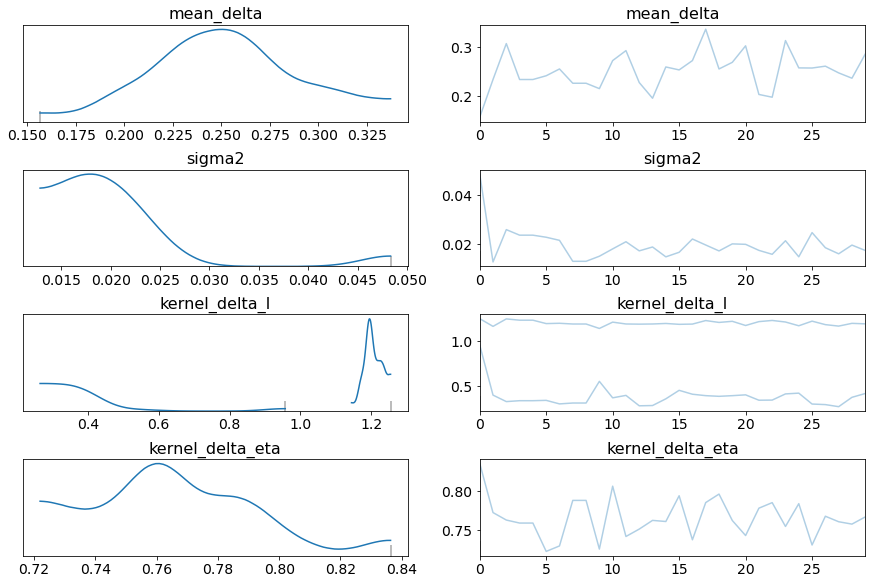

In [5]:
pm.traceplot(trace[10:])
plt.show()

# Evidence computation

In [167]:
model_name = "UNEDF1"
torch.manual_seed(2)
residuals = S2n_train["S2n_16"] - S2n_train[model_name]

data_input = {"Response": residuals.to_numpy(float).flatten(), "X": S2n_train[["Z", "N"]].to_numpy(float)}

In [168]:
time_array_evidence = np.zeros(2)
startTime = time.time()
mc_integral, log_likelihood = evidence_integral(data_input, priors_dictionary, n_mc = 200000)
endTime = time.time()
print(endTime - startTime)
time_array_evidence[1] = endTime - startTime
out_dictionary = {}
out_dictionary["MCMC_time"] = time_array_sampler 
out_dictionary["Evidence_time"] = time_array_sampler 
out_dictionary["integral"] = mc_integral
out_dictionary["likelihood"] = log_likelihood

folder = "Masses_MCMC_" + model_name

if not os.path.exists(folder):
    os.makedirs(folder)

with open(folder + "\outputs" + '.pickle', 'wb') as handle:
    pkl.dump(out_dictionary, handle, protocol=pkl.HIGHEST_PROTOCOL)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mean_delta, kernel_delta_eta, kernel_delta_l, sigma2]
Sampling chain 0, 0 divergences: 100%|███████████████████████████████████████| 210000/210000 [01:56<00:00, 1804.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Log likelihood eval:   0%|          | 0/200000 [00:00<?, ?it/s]

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


KeyboardInterrupt: 

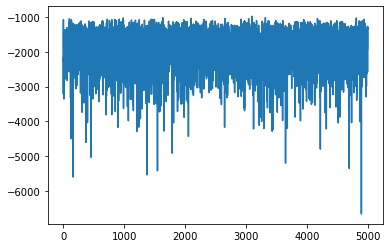

In [42]:
plt.plot(log_likelihood)

In [181]:
with open("HPCC_MCMC\Masses_MCMC_UNEDF1\outputs" + '.pickle', 'rb') as handle:
    test_outputs = pkl.load(handle)

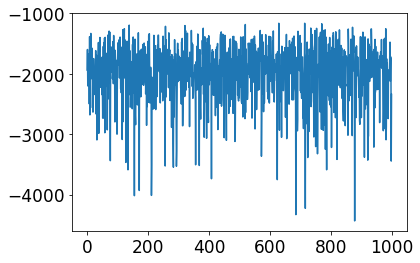

In [171]:
plt.plot(test_outputs["likelihood"])

In [172]:
np.average(test_outputs["likelihood"])

-2007.707375958155

In [174]:
np.average(test_outputs["likelihood"])

-1983.0635656534243

In [176]:
np.average(test_outputs["likelihood"])

-2003.4464771300873

In [178]:
np.average(test_outputs["likelihood"])

-1973.5516110632793

In [180]:
np.average(test_outputs["likelihood"])

-1958.4833722873354

In [182]:
np.average(test_outputs["likelihood"])

-1951.627135765497

# Predictions

In [193]:
# Loading posterior distributions
with open("Masses_RMS_UNEDF1\posterior_samples"  + '.pickle', 'rb') as handle:
    posteriors_VI = pkl.load(handle)

with full_bayes:
    trace_MCMC = pm.backends.ndarray.load_trace("trace_UNEDF1_nsample_10000_sampler_NUTS")
posteriors_MCMC = {}
posteriors_MCMC['beta'] = trace_MCMC['mean_delta']
posteriors_MCMC['eta'] = trace_MCMC['kernel_delta_eta']
posteriors_MCMC['sigma2'] = trace_MCMC['sigma2']
posteriors_MCMC['sigma'] = np.sqrt(trace_MCMC['sigma2'])
posteriors_MCMC['ls'] = trace_MCMC['kernel_delta_l']

model_name = "UNEDF1"
#model_name = sys.argv[1]
torch.manual_seed(2)
residuals_test = S2n_test["S2n_16"] - S2n_test[model_name]
data_input_test = {"Response": residuals_test.to_numpy(float).flatten(), "X": S2n_test[["Z", "N"]].to_numpy(float)}

residuals_train = S2n_train["S2n_16"] - S2n_train[model_name]
data_input_train = {"Response": residuals_train.to_numpy(float).flatten(), "X": S2n_train[["Z", "N"]].to_numpy(float)}

In [194]:
# predictions
torch.manual_seed(2)
n_sample = 10000 # number of posterior samples
n_test = data_input_test["Response"].shape[0]
n_train = data_input_train["Response"].shape[0]

post_samples = {}
post_samples['MCMC'] = np.zeros((data_input_test["Response"].shape[0], n_sample))
post_samples['VBMA'] = np.zeros((data_input_test["Response"].shape[0], n_sample))
X = np.concatenate([data_input_test['X'], data_input_train['X']])

for i in tqdm(range(n_sample), desc= 'MCMC'):
    eta = float(posteriors_MCMC['eta'][-(i + 1)])
    ls = posteriors_MCMC['ls'][-(i + 1)]
    sigma2 = float(posteriors_MCMC['sigma2'][-(i + 1)])
    beta = float(posteriors_MCMC['beta'][-(i + 1)])
    kernel_base = eta ** 2 * skl.RBF(length_scale = ls)
    K = kernel_base(X)
    K11 = K[:n_test,:n_test] + np.diag([sigma2] * n_test)
    K22 = K[n_test:,n_test:] + np.diag([sigma2] * n_train)
    K12 = K[:n_test,n_test:]
    
    mean_pred = np.repeat(beta,n_test)[:,None]
    mean_old = np.repeat(beta,n_train)[:,None]
    
    m_pred = mean_pred + np.dot(K12, np.linalg.solve(K22, data_input_train["Response"][:,None] - mean_old))
    K_pred = K11 - np.dot(K12, np.linalg.solve(K22, K12.T))
    post_samples['MCMC'][:,i] = np.random.multivariate_normal(mean = m_pred.flatten(), cov = K_pred)
    
for i in tqdm(range(n_sample), desc= 'VBMA'):
    eta = float(posteriors_VI['eta'][-(i + 1)])
    ls = posteriors_VI['ls'][-(i + 1)]
    sigma2 = float(posteriors_VI['sigma2'][-(i + 1)])
    beta = float(posteriors_VI['beta'][-(i + 1)])
    kernel_base = eta ** 2 * skl.RBF(length_scale = ls)
    K = kernel_base(X)
    K11 = K[:n_test,:n_test] + np.diag([sigma2] * n_test)
    K22 = K[n_test:,n_test:] + np.diag([sigma2] * n_train)
    K12 = K[:n_test,n_test:]
    
    mean_pred = np.repeat(beta,n_test)[:,None]
    mean_old = np.repeat(beta,n_train)[:,None]
    
    m_pred = mean_pred + np.dot(K12, np.linalg.solve(K22, data_input_train["Response"][:,None] - mean_old))
    K_pred = K11 - np.dot(K12, np.linalg.solve(K22, K12.T))
    post_samples['VBMA'][:,i] = np.random.multivariate_normal(mean = m_pred.flatten(), cov = K_pred)
    
    

MCMC:   0%|          | 0/10000 [00:00<?, ?it/s]

VBMA:   0%|          | 0/10000 [00:00<?, ?it/s]

In [195]:
print("RMSE MCMC:")
print(np.sqrt(np.mean((data_input_test["Response"] - np.mean(post_samples['MCMC'], axis = 1)) ** 2)))
print("RMSE VBMA:")
print(np.sqrt(np.mean((data_input_test["Response"] - np.mean(post_samples['VBMA'], axis = 1)) ** 2)))

RMSE MCMC:
0.41855947400906235
RMSE VBMA:
0.4122917088570487


In [196]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MCMC_cov = []
VBMA_cov = []
for alpha in alphas:
    print("Alpha------------------    " + str(1 - alpha))

    credible_int = {}
    credible_int["MCMC"] = np.zeros((n_test, 2))
    credible_int["VBMA"] = np.zeros((n_test, 2))

    credible_int["MCMC"][:,0] = np.quantile(post_samples["MCMC"], alpha / 2, axis =1)
    credible_int["MCMC"][:,1] = np.quantile(post_samples["MCMC"],1 - alpha / 2, axis =1)
    credible_int["VBMA"][:,0] = np.quantile(post_samples["VBMA"], alpha / 2, axis =1)
    credible_int["VBMA"][:,1] = np.quantile(post_samples["VBMA"],1 - alpha / 2, axis =1)


    # Predictive coverage:
    MCMC_cov = MCMC_cov + [np.sum((data_input_test["Response"] >= credible_int["MCMC"][:,0]) & (data_input_test["Response"] <= credible_int["MCMC"][:,1])) / n_test] 
    print("MCMC predictive coverage: " + str(np.sum((data_input_test["Response"] >= credible_int["MCMC"][:,0]) & (data_input_test["Response"] <= credible_int["MCMC"][:,1])) / n_test))
    
    VBMA_cov = VBMA_cov + [np.sum((data_input_test["Response"] >= credible_int["VBMA"][:,0]) & (data_input_test["Response"] <= credible_int["VBMA"][:,1])) / n_test] 
    print("VBMA predictive coverage: " + str(np.sum((data_input_test["Response"] >= credible_int["VBMA"][:,0]) & (data_input_test["Response"] <= credible_int["VBMA"][:,1])) / n_test))

Alpha------------------    0.9
MCMC predictive coverage: 0.9583333333333334
VBMA predictive coverage: 0.9333333333333333
Alpha------------------    0.8
MCMC predictive coverage: 0.9416666666666667
VBMA predictive coverage: 0.875
Alpha------------------    0.7
MCMC predictive coverage: 0.9166666666666666
VBMA predictive coverage: 0.7916666666666666
Alpha------------------    0.6
MCMC predictive coverage: 0.8083333333333333
VBMA predictive coverage: 0.7333333333333333
Alpha------------------    0.5
MCMC predictive coverage: 0.75
VBMA predictive coverage: 0.675
Alpha------------------    0.4
MCMC predictive coverage: 0.6833333333333333
VBMA predictive coverage: 0.5666666666666667
Alpha------------------    0.30000000000000004
MCMC predictive coverage: 0.5583333333333333
VBMA predictive coverage: 0.5083333333333333
Alpha------------------    0.19999999999999996
MCMC predictive coverage: 0.44166666666666665
VBMA predictive coverage: 0.38333333333333336
Alpha------------------    0.099999999

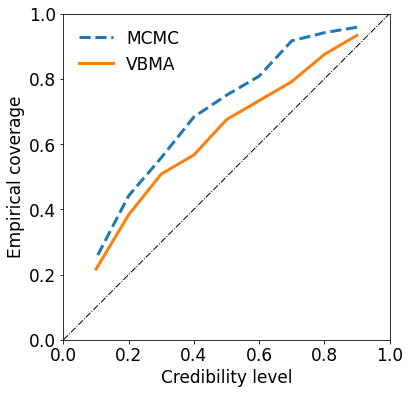

In [197]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 17})
gs = gridspec.GridSpec(1, 1, hspace = 0.001, wspace = 0.001)
lw = 3
ref = np.linspace(0, 1, num = 100)

ax = plt.subplot(gs[0])
ax.plot(1 - np.array(alphas), MCMC_cov, lw =lw, linestyle = '--', label = r"MCMC")
ax.plot(1 - np.array(alphas), VBMA_cov, lw =lw, label = r"VBMA")
ax.plot(ref, ref, lw =1, linestyle = 'dashdot', color = 'black')
ax.set_aspect('equal', adjustable='box')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xlabel(r"Credibility level")
ax.set_ylabel("Empirical coverage")
ax.legend(frameon=False, loc='upper left')
plt.savefig("Mass_coverage_full_RMS.pdf", dpi=500,bbox_inches='tight')
plt.show()